# **Emotion Classificaton in Text - Deep Learning Approach**



In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Tensorflow
try:
  # %tensorflow_version only exists in Colab.
  !pip install -q tf-nightly
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# General
import numpy as np
import pandas as pd
import re

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot') 
# plt.style.use('dark_background')

try:
  import pyprind
except Exception:
  !pip install pyprind
  import pyprind

# Data preprocessing
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 525.1MB 31kB/s 
     |████████████████████████████████| 2.9MB 49.9MB/s 
     |████████████████████████████████| 460kB 56.4MB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import json
import os
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Loading the data

In [0]:
# set the seed for entire process
# so that results can be reproducible
np.random.seed(123)

dataset = pd.read_csv("/content/drive/My Drive/emotion.data")
dataset.drop(dataset.columns[0], axis='columns', inplace=True)    # drop id column since it won't be used 
dataset = dataset.reindex(np.random.permutation(dataset.index))   # shuffle data 
dataset.head()

,text,emotions
302608,i am taking an acid reducer every day and then...,love
283216,i feel gratitude towards those sweet beautiful...,love
266948,i had slept late into the afternoon and awoke ...,joy
391788,i cant tell you how many parent conferences we...,anger
227726,i feel like im slaughtering the tender feeling...,love


## Preprocessing

In [0]:
try:
  stop = stopwords.words('english')
except LookupError:
  import nltk
  nltk.download('stopwords')
  stop = stopwords.words('english')

stop.extend(['img', 'src', 'href'])     # some of these appear in given dataset
print(stop[:10])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


### Tokenizing

In [0]:

def tokenizer(text):
    ''' Removes stop words and special characters,
        and returns list of all words that are left

        Parameters
        -----------
        text : string 

        Returns
        ----------
        tokenized : list {string}
    '''

    text = re.sub('http.*', '', text)                               # delete link references
    text = re.sub('[\W]+', ' ', text.lower()).replace('-', '')      # delete non-word characters [^a-zA-Z0-9]
    tokenized = [w for w in text.split() if w not in stop]          # delete stop words ( I, me , a, the)
    return tokenized


## Creating Train and Test Data

In [0]:
label2id = {"joy" : 0, "sadness" : 1, "anger" : 2, "fear" : 3, "love" : 4, "surprise" : 5}
id2label = {0 : "joy", 1 : "sadness", 2 : "anger", 3 : "fear", 4 : "love", 5 : "surprise"}

label2col = {"joy":"yellow", "sadness":"blue", "anger":"red", "fear":"grey", "love":"pink", "surprise":"orange"}

#label2id = { label : idx for idx, label in enumerate(set(dataset['emotions'].values))}
#id2label = { id : label for label, id in label2id.items()}

print(label2id)
print(id2label)

{'joy': 0, 'sadness': 1, 'anger': 2, 'fear': 3, 'love': 4, 'surprise': 5}
{0: 'joy', 1: 'sadness', 2: 'anger', 3: 'fear', 4: 'love', 5: 'surprise'}


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset['text'].values, 
                                                    dataset['emotions'].values, 
                                                    test_size=0.1, 
                                                    random_state=123)

In [0]:
y_train = [ label2id[val] for val in y_train]
y_test =  [ label2id[val] for val in y_test]

## Training the model

In [0]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [0]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [0]:
y_train = keras.utils.to_categorical(y_train, num_classes=len(label2id), dtype='float32')
y_test = keras.utils.to_categorical(y_test, num_classes=len(label2id), dtype='float32')

y_test.shape

(41682, 6)

## Second model


In [0]:
def create_model_2lstm():
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
  ])
  model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=['accuracy'])
  return model

In [0]:
model2.summary()

NameError: ignored

In [0]:
import os 

model2 = create_model_2lstm()

checkpoint_path_2lstm = "/content/drive/My Drive/Colab Notebooks/training_1/cp16dim2lstm.ckpt"
checkpoint_dir_2lstm = os.path.dirname(checkpoint_path_2lstm)

# Create a callback that saves the model's weights
cp_callback_2lstm = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_2lstm,
                                                 save_weights_only=True,
                                                 verbose=1)

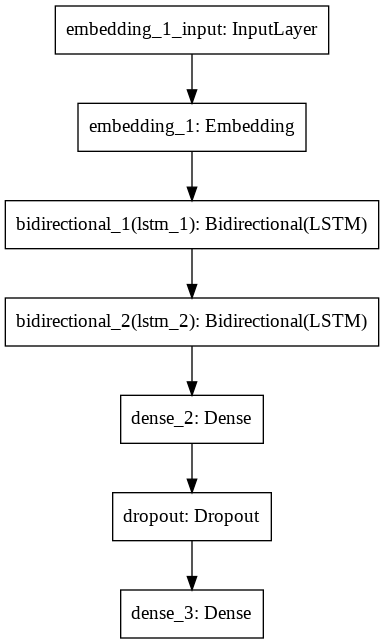

In [0]:
tf.keras.utils.plot_model(
    model2, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [0]:
history_2lstm = model2.fit(training_padded, 
                    y_train, epochs=2, 
                    validation_data=(testing_padded, y_test),
                    callbacks=[cp_callback_2lstm])

Epoch 1/2
11723/11723 [==============================] - ETA: 0s - loss: 0.2191 - accuracy: 0.9000
Epoch 00001: saving model to /content/drive/My Drive/Colab Notebooks/training_1/cp16dim2lstm.ckpt
11723/11723 [==============================] - 1982s 169ms/step - loss: 0.2191 - accuracy: 0.9000 - val_loss: 0.0941 - val_accuracy: 0.9395
Epoch 2/2
 5317/11723 [============>.................] - ETA: 17:33 - loss: 0.0965 - accuracy: 0.9388

KeyboardInterrupt: ignored

In [0]:
model2 = create_model_2lstm()

model2.load_weights(checkpoint_path_2lstm)

loss,acc = model2.evaluate(testing_padded,  y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1303/1303 - 42s - loss: 0.0941 - accuracy: 0.9395
Restored model, accuracy: 93.95%


In [0]:
# NEW
calculate_metrics(model2)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     14156
           1       0.98      0.97      0.97     12141
           2       0.93      0.95      0.94      5678
           3       0.89      0.93      0.91      4813
           4       1.00      0.69      0.82      3405
           5       0.86      0.77      0.81      1489

   micro avg       0.94      0.94      0.94     41682
   macro avg       0.93      0.88      0.90     41682
weighted avg       0.94      0.94      0.94     41682
 samples avg       0.94      0.94      0.94     41682

Accuracy: 93.95%


## 2 LSTM 100 dim

In [0]:
model100dim = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
  ])
model100dim.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=['accuracy'])

In [0]:
model100dim.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 100, 128)          84480     
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 390       
Total params: 1,130,246
Trainable params: 1,130,246
Non-trainable params: 0
____________________________________________

In [0]:
model100dim.fit(training_padded, 
                    y_train, epochs=3, 
                    validation_data=(testing_padded, y_test))

Epoch 1/3
11723/11723 [==============================] - 2264s 193ms/step - loss: 0.0918 - accuracy: 0.9413 - val_loss: 0.0946 - val_accuracy: 0.9397
Epoch 2/3
11723/11723 [==============================] - 2257s 192ms/step - loss: 0.0886 - accuracy: 0.9422 - val_loss: 0.0896 - val_accuracy: 0.9401
Epoch 3/3
11723/11723 [==============================] - 2228s 190ms/step - loss: 0.0866 - accuracy: 0.9430 - val_loss: 0.0897 - val_accuracy: 0.9385


## Model 100 dim more params

In [5]:
model100dim = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
  ])
model100dim.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=['accuracy'])

model100dim

In [0]:
def create_big_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
  ])

  model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=['accuracy'])
  return model

In [0]:
import os

checkpoint_path_100dim = "/content/drive/My Drive/Colab Notebooks/training_1/cp100dim2lstm.ckpt"
checkpoint_dir_100dim = os.path.dirname(checkpoint_path_100dim)

# Create a callback that saves the model's weights
cp_callback_100dim = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_100dim,
                                                 save_weights_only=True,
                                                 verbose=1)

In [0]:
history = model100dim.fit(training_padded, 
                          y_train, 
                          epochs=10, 
                          validation_data=(testing_padded, y_test),
                          callbacks=[cp_callback_100dim])

Epoch 1/10
11723/11723 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 0.9048
Epoch 00001: saving model to /content/drive/My Drive/Colab Notebooks/training_1/cp100dim2lstm.ckpt
11723/11723 [==============================] - 2762s 236ms/step - loss: 0.2075 - accuracy: 0.9048 - val_loss: 0.0975 - val_accuracy: 0.9403
Epoch 2/10
11723/11723 [==============================] - ETA: 0s - loss: 0.0979 - accuracy: 0.9401
Epoch 00002: saving model to /content/drive/My Drive/Colab Notebooks/training_1/cp100dim2lstm.ckpt
11723/11723 [==============================] - 2763s 236ms/step - loss: 0.0979 - accuracy: 0.9401 - val_loss: 0.0915 - val_accuracy: 0.9403
Epoch 3/10
11723/11723 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.9416
Epoch 00003: saving model to /content/drive/My Drive/Colab Notebooks/training_1/cp100dim2lstm.ckpt
11723/11723 [==============================] - 2761s 235ms/step - loss: 0.0916 - accuracy: 0.9416 - val_loss: 0.0917 - val_

## Load the big model

In [0]:
model = create_big_model()

model.load_weights(checkpoint_path_100dim)

loss,acc = model.evaluate(testing_padded,  y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1303/1303 - 10s - loss: 0.1017 - accuracy: 0.9426
Restored model, accuracy: 94.26%


In [0]:
calculate_metrics(model)

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     14156
           1       0.97      0.98      0.98     12141
           2       0.95      0.94      0.95      5678
           3       0.88      0.95      0.91      4813
           4       0.77      1.00      0.87      3405
           5       0.89      0.75      0.81      1489

   micro avg       0.94      0.94      0.94     41682
   macro avg       0.91      0.92      0.91     41682
weighted avg       0.95      0.94      0.94     41682
 samples avg       0.94      0.94      0.94     41682

Accuracy: 94.26%


In [0]:
sequences = tokenizer.sequences_to_texts(training_sequences)
vocab = set()

for seq in sequences:
  for word in seq.split(" "):
    vocab.add(word)

In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 100)


In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(vocab):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

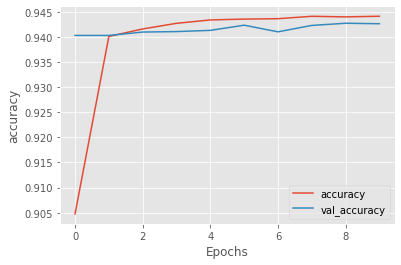

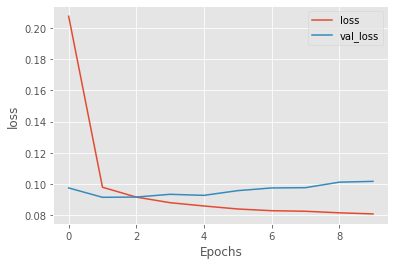

In [0]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [0]:
from sklearn.metrics import classification_report

def calculate_metrics(model):
  y_pred = model.predict(testing_padded)
  for idx, array in enumerate(y_pred):
    y_pred[idx] = convert_to_one_hot(array)

  # Calculate F-Score
  print(classification_report(y_test, y_pred))

  # Calculate Accuracy
  correct = 0
  for idx in range(len(y_pred)):
    if np.argmax(y_pred[idx]) == np.argmax(y_test[idx]):
      correct += 1

  print("Accuracy: {:5.2f}%".format(100*correct/len(y_pred)))


def convert_to_one_hot(array):
  maks = np.argmax(array)
  array = [0.] * len(array)
  array[maks] = 1.
  return array
    